In [1]:
# Dependencies
import os
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from experiment_runner_utils_final import (parse_rna,
                                     parse_metadata,
                                     Deseq2AnalysisClass,
                                     calculate_and_plot_genesets,
                                     parse_gsea_df,
                                     DnaMutationNewAnalyser)

## Setup required Transcriptomics and genomics files

In [2]:
# Load in RNA data
gene_counts = pd.read_csv(r"C:\Users\judeh\Desktop\lung_cancer\lung_cancer\data\raw_data\data_mrna_seq_v2_rsem.txt", sep='\t')
gene_counts = parse_rna(gene_counts)

dna_mutations = pd.read_csv(r"C:\Users\judeh\Desktop\lung_cancer\lung_cancer\data\raw_data\TCGA-LUAD.mutect2_snv.tsv", sep='\t')
dna_mutations.head(5)

,Sample_ID,gene,chrom,start,end,ref,alt,Amino_Acid_Change,effect,filter,dna_vaf
0,TCGA-97-7938-01A,PTCHD2,chr1,11517599,11517599,C,A,p.T629N,missense_variant,PASS,0.368421
1,TCGA-97-7938-01A,HNRNPCL1,chr1,12847895,12847895,G,T,p.P132H,missense_variant,PASS,0.381579
2,TCGA-97-7938-01A,PADI1,chr1,17230152,17230152,A,G,p.N333D,missense_variant,PASS,0.191011
3,TCGA-97-7938-01A,SH2D5,chr1,20727574,20727574,C,G,p.L39L,synonymous_variant,PASS,0.315789
4,TCGA-97-7938-01A,ARID1A,chr1,26771167,26771167,G,T,p.G1083C,missense_variant,PASS,0.348837


## Setup experiment design

In [3]:
# experimental setup
experiment_name = 'my cool experiment'
save_path = f'results/{experiment_name}'

# if save_path does not exist, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

metadata_filepath = r"C:\Users\judeh\Desktop\lung_cancer\lung_cancer\data\meta_data\os_late_stage_meta.csv"
metadata_label_string = '3_year_survival'
metadata_label_group1 = 'dead'
metadata_label_group2 = 'alive'

metadata = parse_metadata(metadata_filepath, metadata_label_string)


## Perform DESeq2 analysis

C:\Users\judeh\anaconda3\envs\lung_cancer\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.33 seconds.

Fitting dispersions...
... done in 13.85 seconds.

Fitting dispersion trend curve...
... done in 2.46 seconds.

Fitting MAP dispersions...
... done in 16.26 seconds.

Fitting LFCs...
... done in 6.69 seconds.

Calculating cook's distance...
... done in 0.57 seconds.

Replacing 2428 outlier genes.

Fitting dispersions...
... done in 1.98 seconds.

Fitting MAP dispersions...
... done in 2.15 seconds.

Fitting LFCs...
... done in 1.04 seconds.

Running Wald tests...
... done in 3.76 seconds.



Log2 fold change & Wald test p-value: 3_year_survival dead vs alive
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
LOC100130426     0.010441        0.027835  3.664154  0.007596  0.993939   
UBE2Q2P3         9.364539       -0.229706  0.310409 -0.740009  0.459295   
HMGB1P1        109.265503        0.209779  0.149192  1.406105  0.159693   
TIMM23        1024.358823       -0.195906  0.139427 -1.405080  0.159997   
MOXD2            0.000000             NaN       NaN       NaN       NaN   
...                   ...             ...       ...       ...       ...   
ZYX           4249.341455        0.181923  0.177569  1.024515  0.305592   
FLJ10821      1019.356110       -0.190737  0.144686 -1.318278  0.187411   
ZZZ3           763.745456        0.058812  0.161992  0.363057  0.716562   
TPTEP1         175.064961        0.126953  0.517331  0.245400  0.806146   
AKR1C6P          0.071471       -0.474290  2.965634 -0.159929  0.872937   

                  padj  
LOC100

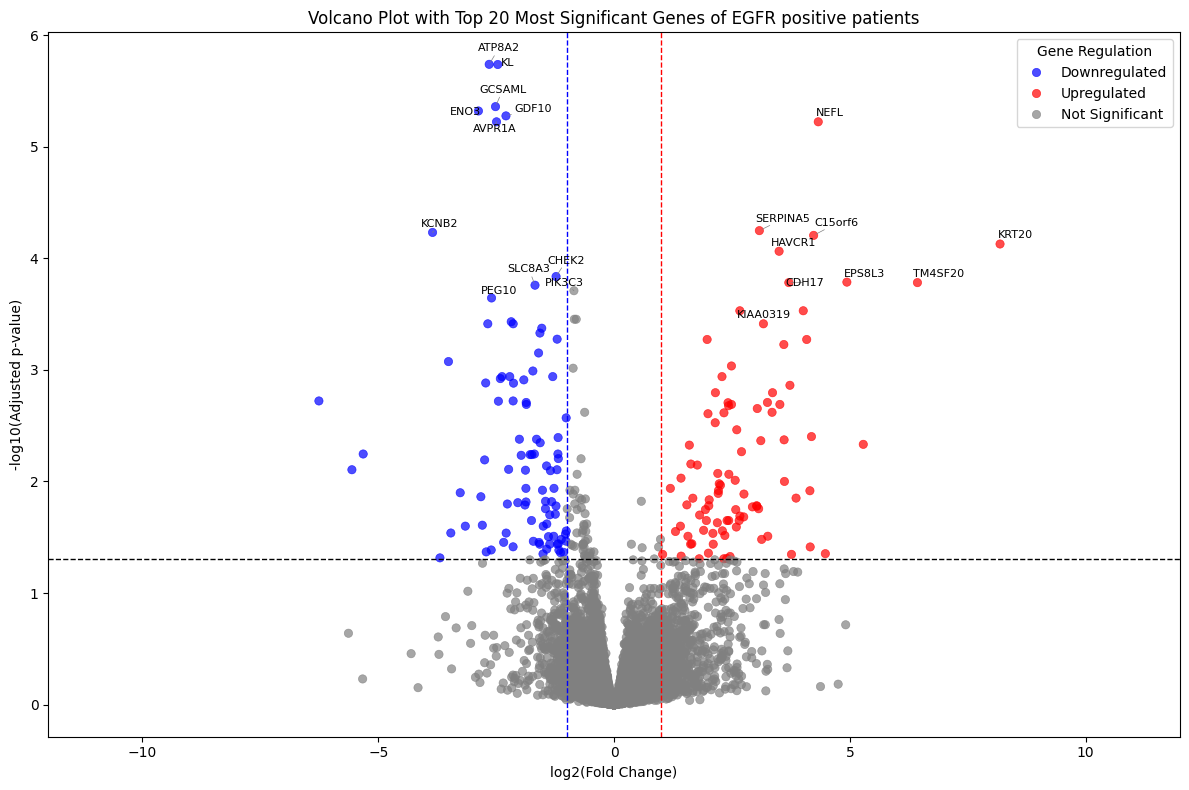

In [4]:
analysis = Deseq2AnalysisClass(gene_counts=gene_counts, metadata=metadata, save_path=save_path)

# Run DESeq2 analysis
results = analysis.perform_deseq2(
    metadata_column=metadata_label_string,
    group_1=metadata_label_group1,
    group_2=metadata_label_group2,
)

volcano_fig = analysis.volcano_plot()

## Perform GSEA analysis

In [5]:
gsea_df = parse_gsea_df(results)

Running GSEA for gene set: GO_Biological_Process_2025


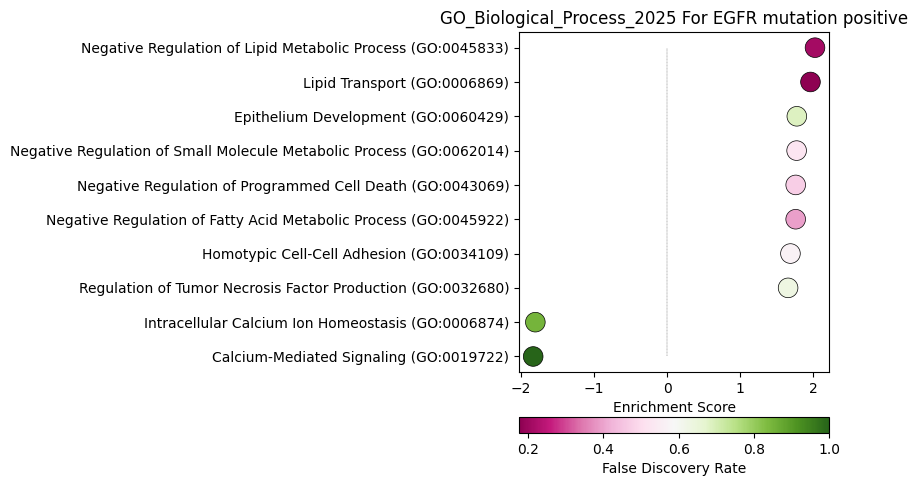

In [6]:
gsea_results_df, gsea_fig = calculate_and_plot_genesets(
    raw_df=gsea_df,
    n_top_genes=1000,
    plot_n_genesets=10,
    gene_set="GO_Biological_Process_2025"
)

## Perform mutational analysis

In [7]:
analyzer = DnaMutationNewAnalyser(metadata= metadata,
                                  dna_mutations= dna_mutations,
                                  metadata_label_string= metadata_label_string,
                                  metadata_label_group1= metadata_label_group1,
                                  metadata_label_group2= metadata_label_group2,
                                  experiment_name= experiment_name,
                                  save_path=save_path)

analyzer.compute_stats()

group 1: 79
group 2: 20


100%|████████████████████████████████████████████████████████████████████████████| 18966/18966 [13:06<00:00, 24.11it/s]


,gene,group_1_with_mut,group_1_without_mut,group_2_with_mut,group_2_without_mut,chi2_p,mwu_p,chi2_neglogp,mwu_neglogp
0,PTCHD2,2,77,2,18,0.379073,1.0,0.421277,-0.0
1,HNRNPCL1,0,79,2,18,0.051185,1.0,1.290857,-0.0
2,PADI1,2,77,0,20,1.000000,1.0,-0.000000,-0.0
3,SH2D5,1,78,0,20,1.000000,1.0,-0.000000,-0.0
4,ARID1A,5,74,1,19,1.000000,1.0,-0.000000,-0.0
...,...,...,...,...,...,...,...,...,...
18961,MSANTD2,1,78,0,20,1.000000,1.0,-0.000000,-0.0
18962,FAM83E,0,79,0,20,1.000000,1.0,-0.000000,-0.0
18963,ZMYND19,0,79,0,20,1.000000,1.0,-0.000000,-0.0
18964,CLEC4C,0,79,0,20,1.000000,1.0,-0.000000,-0.0


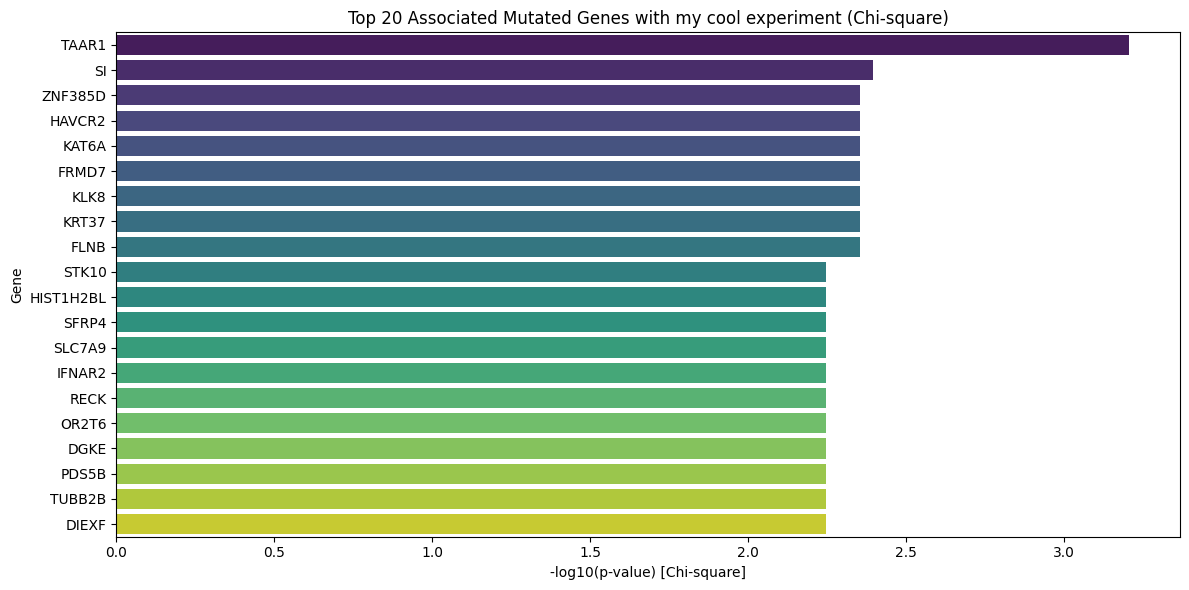

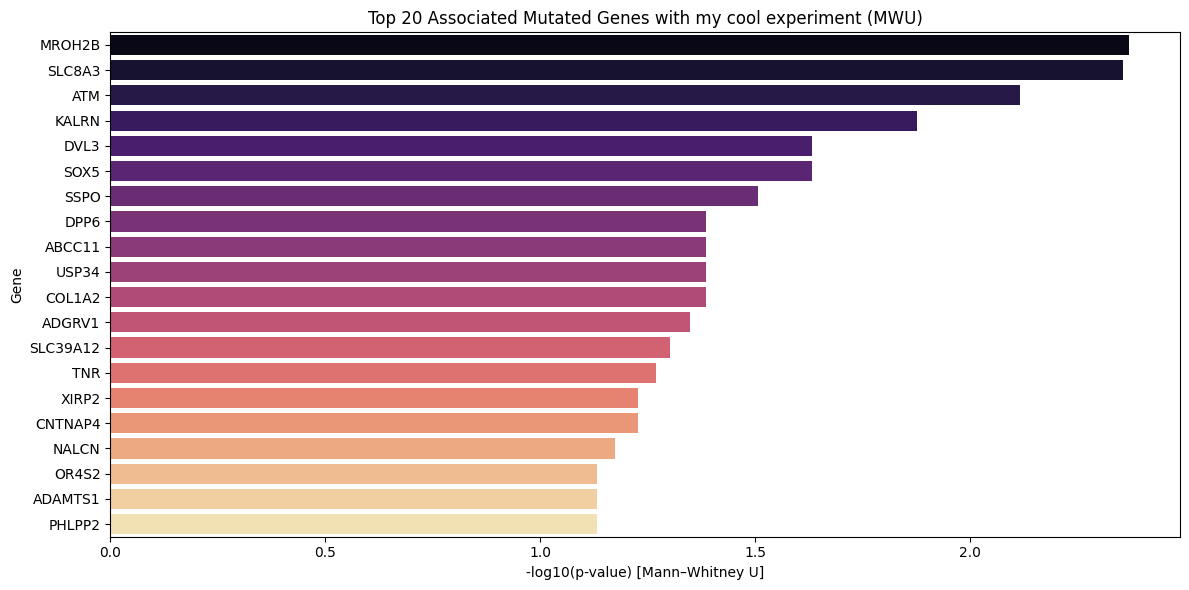

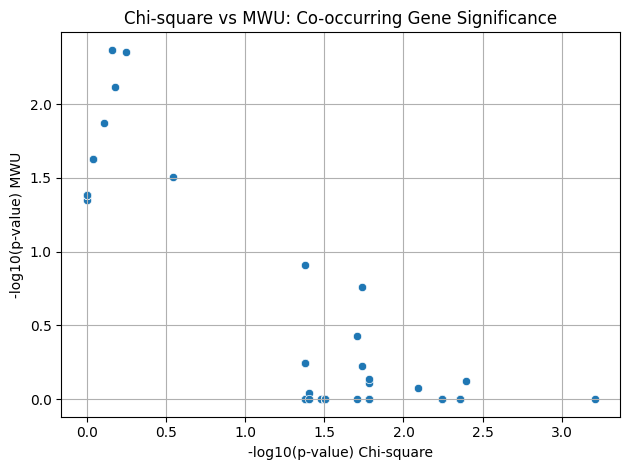

In [8]:
analyzer.plot_bar_charts()
analyzer.plot_scatter()

In [9]:
gene_counts.head(5)
metadata.head(5)
merged_df = metadata.merge(gene_counts, left_index=True, right_index=True)
merged_df.head(5)

#machine learning setup
X= merged_df.drop(columns=[metadata_label_string])
X.columns = X.columns.astype(str)
y = merged_df[metadata_label_string]
y = y.map({metadata_label_group1: 0, metadata_label_group2: 1})
X.head(5), y.head(5)

(                  LOC100130426  UBE2Q2P3   HMGB1P1    TIMM23  MOXD2  \
 TCGA-62-A46Y-01A           0.0   14.4261  111.4085  840.6015    0.0   
 TCGA-55-8092-01A           0.0   11.8511   88.7411  859.9185    0.0   
 TCGA-05-4396-01A           0.0   13.5406  108.4155  844.5792    0.0   
 TCGA-44-3396-01A           0.0   12.9268   71.4657  678.0040    0.0   
 TCGA-05-5429-01A           0.0    0.0000  119.3735  996.1330    0.0   
 
                   LOC155060  RNU12-2P    SSX9  LOC317712   EZHIP  ...  \
 TCGA-62-A46Y-01A   460.1504    0.5013  0.0000        0.0  0.0000  ...   
 TCGA-55-8092-01A   317.1867    1.3346  0.0000        0.0  0.4449  ...   
 TCGA-05-4396-01A   190.2957    0.7582  0.0000        0.0  0.0000  ...   
 TCGA-44-3396-01A   387.5587    0.0000  1.7901        0.0  0.6713  ...   
 TCGA-05-5429-01A    33.2560    0.0000  0.0000        0.0  0.0000  ...   
 
                      ZXDA      ZXDB       ZXDC   ZYG11A    ZYG11B        ZYX  \
 TCGA-62-A46Y-01A  35.5890  291.2281   

OOF ROC AUC Score: 0.5500


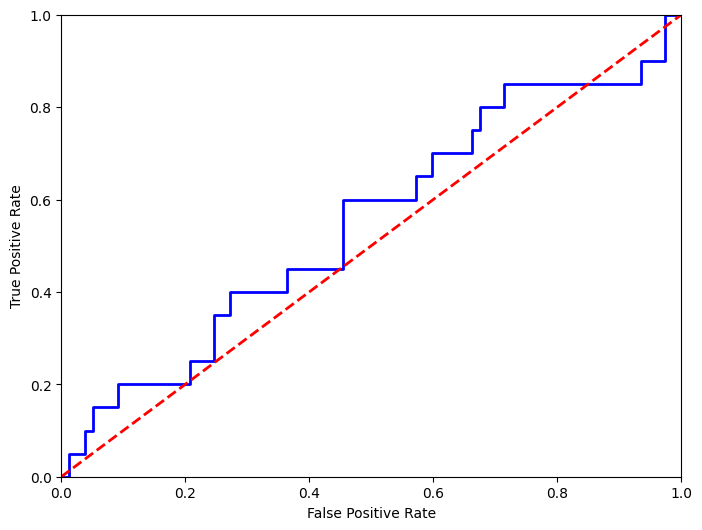

In [10]:
# Machine learning

## Define the pipeline
pipeline = make_pipeline(
    StandardScaler(),    
    LogisticRegression(max_iter=1000, random_state=42))   
    
##randomforestclassifier((n_estimators=100, random_state=42)_ <- random forest not in use 

## Get out-of-fold predicted probabilities
oof_preds = cross_val_predict(    
    pipeline, 
    X, 
    y,    
    cv=5,    
    method='predict_proba')

## Get probabilities for the positive class (usually class 1)
oof_preds_pos = oof_preds[:, 1]

## Calculate ROC AUC from OOF predictions
oof_auc = roc_auc_score(y, oof_preds_pos)
print(f"OOF ROC AUC Score: {oof_auc:.4f}")

## get preds for auc with out of fold predictions
## generate auc curve
fpr, tpr, thresholds = roc_curve(y, oof_preds_pos)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  

## Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()